# Template for multi-pitch detection TP

*(reference: Klapuri) but with pitch detection with spectral sum

*From G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [516]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil

Functions

In [517]:
def load_music(file):
    return wave.open(file, 'rb')


def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_


def f2idx(F, df):
    """
    Convert frequency to corresponding index in "frequencies" array
    """
    return ceil(F/df)

## 0 - Reading and playing .wav file

Choose the name of music for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [562]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'sons_multipitch')
# filename = 'A3C4E4G4_piano.wav'
# filename="A3A4A5_duo.wav"
# filename = 'E4_oboe.wav'
# filename = 'A3_piano.wav'
filename = 'A4_piano.wav'
#filename = 'C4F#4_Oboe_16.wav'
music = os.path.join(data_path, filename) 

### **Using wave**

In [563]:
wavefile = load_music(music)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=32000, nframes=31994, comptype='NONE', compname='not compressed')


In [564]:
play = True
if play :
    play_music(music) 

In [565]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
print('Fs is equal to '+str(Fs)+' Hz')

Fs is equal to 32000 Hz


In [566]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

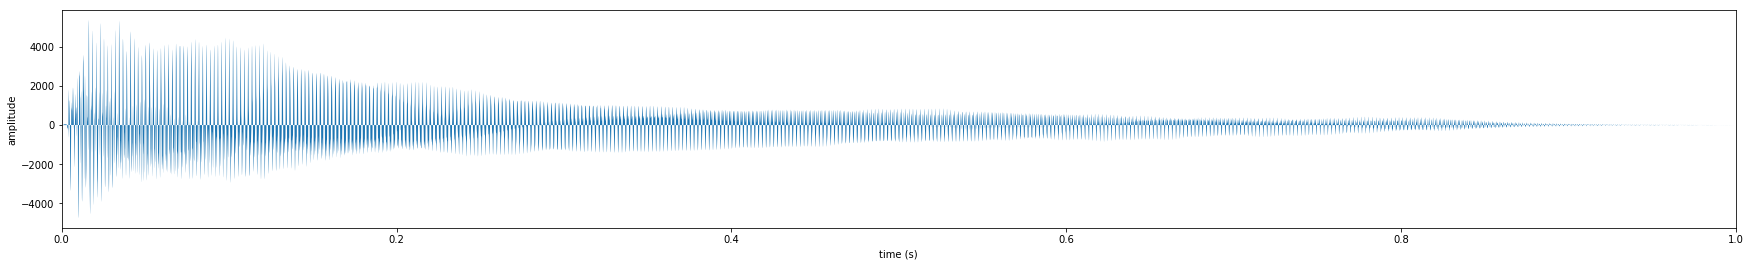

In [567]:
plot_sound(x, times)

## I - Window and Fast Fourier Transform


**1. Window size :** A Hamming window is used, its length covering $700$ ms of the entire signal. 

**2. Offset :** The offset is the chosen delay from which we consider the signal, it is chosen to be about $100$ ms. It's main purpose is to discard the attack of the sound.

**3. Spectral precision after the FFT :** The frequency precision is given by $dF_{\text{min}}=\frac{F_{s}}{Nfft}$, where $Nfft$ is the size of the FFT window. 


In [568]:
N=ceil(0.7*Fs)       # Window size of analysed signal (only one window of signal is analysed)
dF_min=Fs/N   # Minimal frequency resolution
print('The minimal frequency resolution is of {:.2f} Hz'.format(dF_min))
print('N is equal to '+str(N))

The minimal frequency resolution is of 1.43 Hz
N is equal to 22400


In [569]:
w=np.hamming(N)  # Window
width = 4*dF_min # largeur du pic spectral (en Hz) 4*dF_min
eps=float(1e-20)   #precision

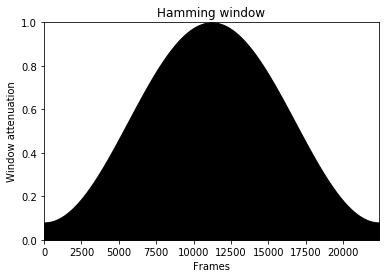

In [570]:
plt.fill_between(np.arange(len(w)), w, color='k')
plt.title('Hamming window')
plt.xlabel('Frames')
plt.ylabel('Window attenuation')
plt.xlim(0, len(w))
plt.ylim(0, 1)
plt.show()

### Discarding the attack of the sound

In [571]:
offset=ceil(0.1*Fs)
xw=x[offset:offset+N]*w    # xw is the analysed signal frame
n_xw = xw.size

In [572]:
print("The length of  the sound we will be working on is equal to.",xw.size)

The length of  the sound we will be working on is equal to. 22400


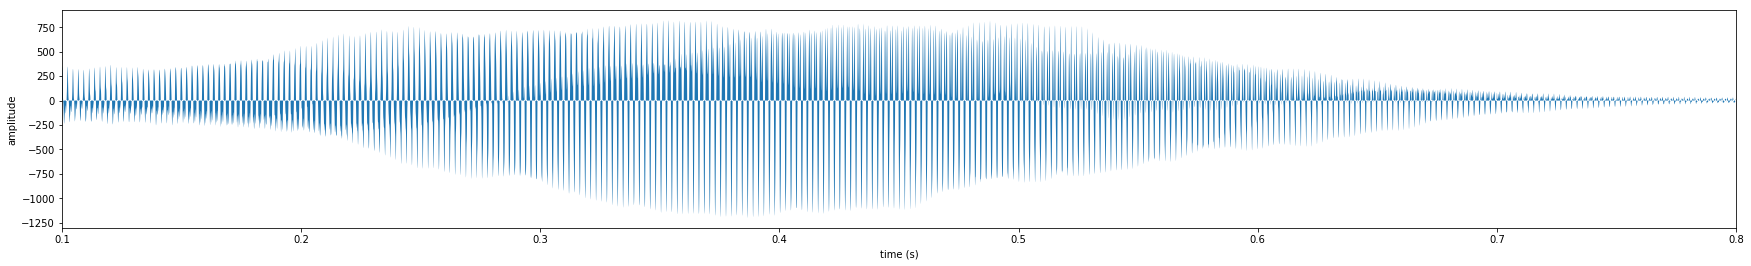

In [573]:
plot_sound(xw, times[offset:offset+N])

This is the temporal visualization of the sound we will be working on.

### Processing for efficient FFT (*by truncating to powers of 2*)

In [574]:
#Minimal number of data points to satisfy the minimal frequency resolution
Nfft_min=Fs/dF_min

#compute the smallest power of two that satisfies the minimal frequency resolution for FFT
p, Nfft = nextpow2(Nfft_min)
x_fft = np.fft.fft(xw, n=Nfft) #calcul FFT
x_fft /= np.max(np.abs(x_fft))+eps # Normalization

df=Fs/Nfft # frequency virtual resolution of FFT 
print('Frequency virtual resolution of FFT {:.2} Hz'.format(df))

Frequency virtual resolution of FFT 0.98 Hz


In [575]:
frequencies = np.arange(Nfft)*df  # equivalent to np.fft.fftfreq(n=Nfft, d=timestep)
X_fft = np.abs(x_fft) # absolute value of FFT (phase doesn't play a role)

Plot FFT spectrum

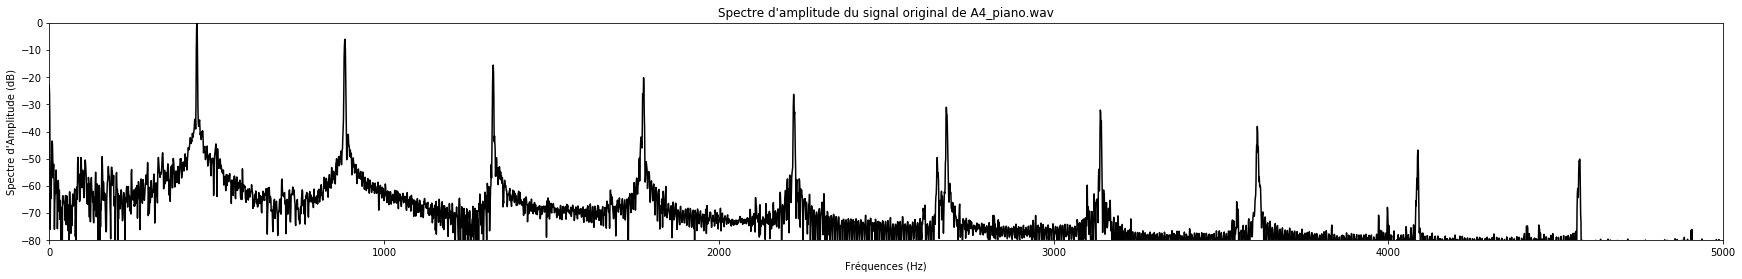

In [576]:
plt.figure(figsize=(30, 4))
plt.plot(frequencies[:int(Nfft/2)], 20*np.log10(X_fft[:int(Nfft/2)]), color='k')
plt.xlim(0, 5000)
plt.ylim(-80, 0)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title('Spectre d\'amplitude du signal original de '+filename)
plt.show()

For **A4_piano.wav**, we clearly see the harmonic around $\sim 440$ Hz and partials (multiples of the fundamental frequency peak).

## Answers:
> **1)** The choice of the window size must be done considering the frequency of the signal. If these factors evolve, this must be taken into account. The lowest detectable frequency (F0) is determined by the size – duration – of the window.$ F_{0}$= 5 $\frac{Sampling Rate}{Window size}$\\
In this case, we have : $5 \frac{22400}{700}$ = 160 Hz is the lowest detectable frequency, which means that we will be able de detect notes with highest frequencies.

> **2)** The offset is the chosen delay from which we consider the signal, it is chosen to be about $100$ ms. It's main purpose is to discard the attack of the sound.

> **3)** The frequency precision is given by $dF_{\text{min}}=\frac{F_{s}}{Nfft}$, where $Nfft$ is the size of the FFT window. For the file "A3_piano.wav", The precision is 1.43 Hz.


## II - Fundamental frequency estimation by spectral product/sum method

The different steps include :

#loop on the number of pitches
    - example criterion could use an energy ratio "while criterion > seuil_F0"
    
  #Detection of main F0
  
        -Compute spectral sum
        -locate maximum
        -store value of estimated F0

  #Subtraction of main note (Main F0 with its harmonics)
        
        -localisation of harmonics around theoretical values (with or without inharmonicy coefficient) 
        - beta: harmonicity coefficient ;  alpha: coefficient of tolerance
                
        - Harmonic suppression (wideness of an harmonic to be suppressed depends on the main lob of the TF of the analysis window); suppression of harmonics is done on abs(Xk) on forcing all values of a harmonic peak to the minimum value of the peak (e.g. the level of noise).
         
#end of loop

In [577]:
Fmin=50           # Minimal F0 frequency that can be detected
Fmax=900             # Maximal F0 frequency that can be detected
H=4                  # H = nombre de versions compressées
Rmax = ceil((Nfft-1)/(2*H)) # fréquence maximale 

In [578]:
print('The maximum value of R that can be used is '+str(Rmax))

The maximum value of R that can be used is 4096


## Answers :
> 4) The maximum frequency that can be used for the computation of S is equal to $\frac{H*R*Fs}{Nfft}$

> 5) The maximum value of R that can be used for the computation of S is $R_{max}$ for which $\frac{H*R*Fs}{Nfft}$ is equal to Nequist Frequency. So Rmax = $\frac{Nfft}{2H}$

> 6) Below we code the function spectral_prod and spectral sum. In this part we use spectral sum

In [579]:
print('Rmax is equal to '+str(Rmax))

Rmax is equal to 4096


### Computation of the spectral sum & product sum

Functions sum and product

In [580]:
def spectral_prod(x, R, H):
    """
    Spectral Product
    """
    p = []
    for k in range(R):
        p.append(np.prod([abs(x[j*k]) for j in range(H)]))
    return np.array(p)


def spectral_sum(x, R, H):
    """
    Spectral sum
    """
    s = []
    for k in range(R):
        s.append(np.sum([abs(x[j*k]) for j in range(H)]))
    return np.array(s)


def spectral_method(x, R, H, method='product'):
    """
    Factorization of previous methods
    """
    assert method in ['sum', 'product']
    if method == 'sum':
        return spectral_sum(x, R, H)
    else:
        return spectral_prod(x, R, H)

Maximum Search

### Finding the spectral sum maximum

In [581]:
Nmin = f2idx(Fmin,df)-1
Nmax = f2idx(Fmax,df)
assert Nmax <= Rmax and Nmin >= 0
print("Nmin = ",Nmin," Nmax = ", Nmax)

Nmin =  51  Nmax =  922


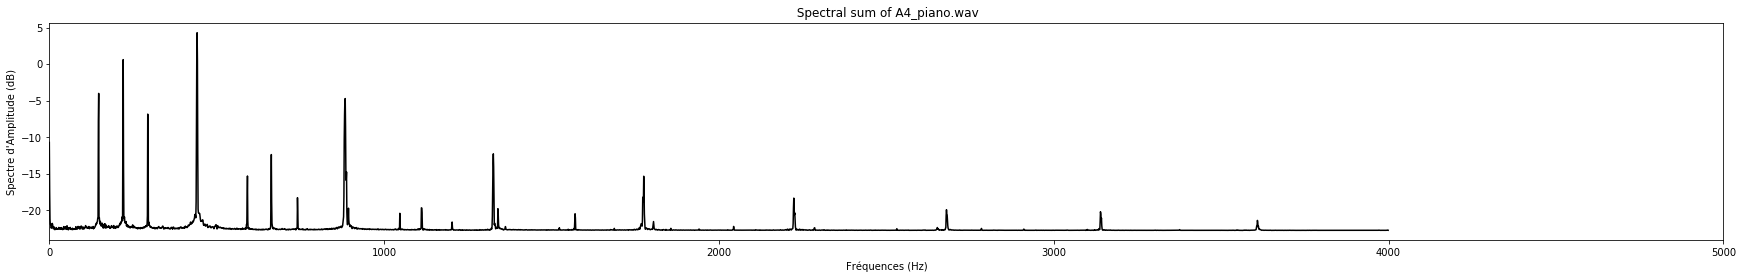

In [582]:
method = 'sum'
P_prod = spectral_method(X_fft, Rmax, H, method)
plt.figure(figsize=(30, 4))
plt.plot(frequencies[:Rmax], 20*np.log10(P_prod[:Rmax]), color='k')
plt.xlim(0, 5000)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title(' Spectral '+ method + " of " + filename)
plt.show()

In [583]:
print('The maximal amplitude is obtained with frequency of ' + str(frequencies[np.argmax(P_prod[Nmin:Nmax])+Nmin]) +' Hz and the amplitude is '+str(np.max(P_prod[Nmin:Nmax])))

The maximal amplitude is obtained with frequency of 441.40625 Hz and the amplitude is 1.638982104238515


In [584]:
method = 'product'
P_prod = spectral_method(X_fft, Rmax, H, method)

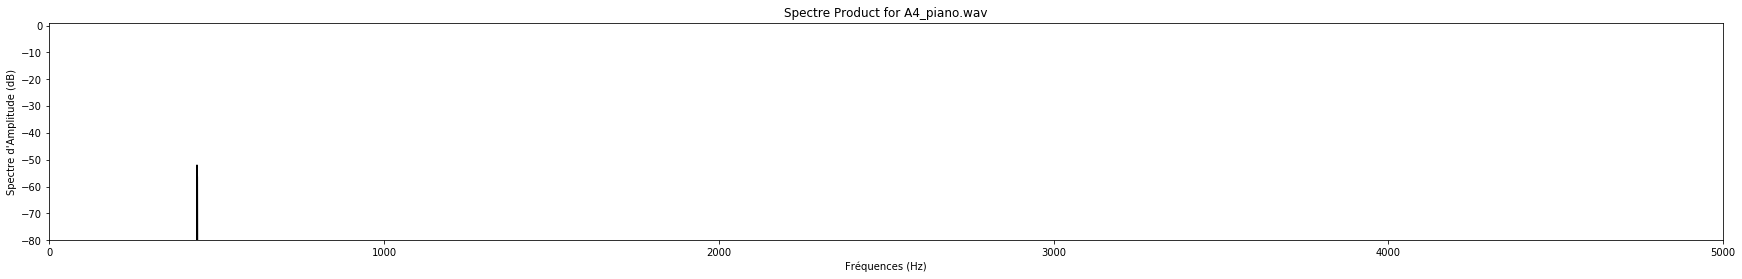

In [585]:
plt.figure(figsize=(30, 4))
plt.plot(frequencies[:Rmax], 20*np.log10(P_prod), color='k')
plt.xlim(0, 5000)
plt.ylim(-80, 1)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title('Spectre Product for '+filename)
plt.show()

In [586]:
print('The maximal amplitude is obtained with frequency of ' + str(frequencies[np.argmax(P_prod[Nmin:Nmax])+Nmin]) +' Hz and the amplitude is '+str(np.max(P_prod[Nmin:Nmax])))

The maximal amplitude is obtained with frequency of 441.40625 Hz and the amplitude is 0.002505412673937978


> Thanks to Spectral Sum we could detect the fundamental frequency for "A4-piano" F0= **441.4 Hz**

> ### Testing the method on E4_oboe.wav

> The figures below present the results of the method tested on E4_oboe.wav file

> This figure presents the signal's spectrum. We can notice that it is noisy. 

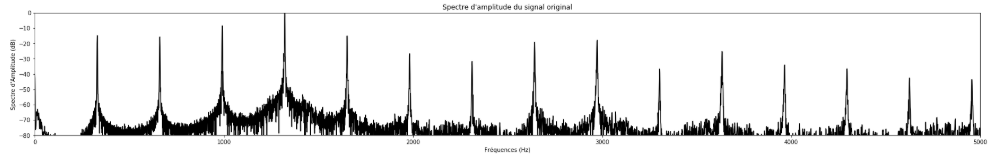

> Below is the spectral sum amplitudes

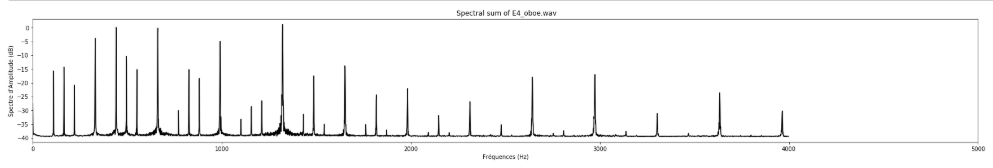

> We can notice that the fundamental frequency is between 300 Hz and 400 Hz. Yet, the sum product detected a maximum amplitude with frequency of 440.4296875. Hence, we can conclude that the spectral sum is not very discriminating because of the noise.

> We tried with the spectral product and we could detect the right frequency, the maximal amplitude is obtained with frequency of 330.078125 Hz. Thus, the Spectral Product is more accurate.

> We can notice that we get both for Sum and Product the maximal amplitude for 441.4 HZ (which is the fundamental frequency). Nonetheless the Product is more accurate as we can notice in  the above graphs.

# Substraction of the sound 

Harmonics detection

In [587]:
def detect_harmonic(x,R,H,alpha,method,k,freq):
    """
    x:
    R:
    H:
    alpha:
    method:
    k:
    freq
    """
    P_sum= spectral_method(x, R, H, method)
    f=freq[np.argmax(P_sum[Nmin:Nmax])+Nmin]
    
    f_kmin=f*k*(1-alpha)
    f_kmax=f*k*(1+alpha)
    i0=f2idx(f*k,df)
    i=i0
    if i0==0:
        return(i0)
        
    else:
        while freq[i]>=f_kmin:
            if abs(x[i])>abs(x[i0]) :
                i0=i
            i=i-1
        while freq[i]<=f_kmax:
            if abs(x[i])>abs(x[i0]) :
                i0=i
            i+=1
            if i>=len(freq)-2*i0:
                break
        return(i0)

> we have to choose $\alpha$ so that the search interval does not overlap with an interval containing a previous or next harmonic. Below we choose $\alpha$ = 0.02

In [588]:
#test
print("The second harmonic frequency :  ", frequencies[detect_harmonic(X_fft, Rmax, H, 0.02,"product",2,frequencies)],
      "which is different from 1 x F0 = ", 2* frequencies[detect_harmonic(X_fft, Rmax, H, 0.02,"product",1,frequencies)] )
print("The third harmonic frequency :  ", frequencies[detect_harmonic(X_fft, Rmax, H, 0.02,"product",3,frequencies)],
      "which is different from 3 x F0 = ", 3* frequencies[detect_harmonic(X_fft, Rmax, H, 0.02,"product",1,frequencies)] )


The second harmonic frequency :   883.7890625 which is different from 1 x F0 =  882.8125
The third harmonic frequency :   1326.171875 which is different from 3 x F0 =  1324.21875


> This method is not adapted for all kinds of instruments especially for those that have close harmonics.

Harmonics suppression

In [589]:
bin_width = np.mean((4+eps)/w)
def harmonic_suppression(x,R,H,alpha,method,freq):
    x1=x.copy()
    F_lim=0
    i=1
    P_sum= spectral_method(x, R, H, method)
    j0=np.argmax(P_sum[Nmin:Nmax])+Nmin
    while F_lim<=freq[-1]-2*freq[j0] :
        j=detect_harmonic(x,R,H,alpha,method,i,freq)
        x1[j-int(bin_width):j+int(bin_width)]=min(x[j-int(bin_width):j+int(bin_width)])
        F_lim=freq[j]
        i+=1
        if f2idx(freq[j0]*i,df) > len(freq)-1:
            break
    return x1

In [590]:
'La largeur est de '+str(int(bin_width)) +' Hz.'

'La largeur est de 14 Hz.'

### Affichage du signal

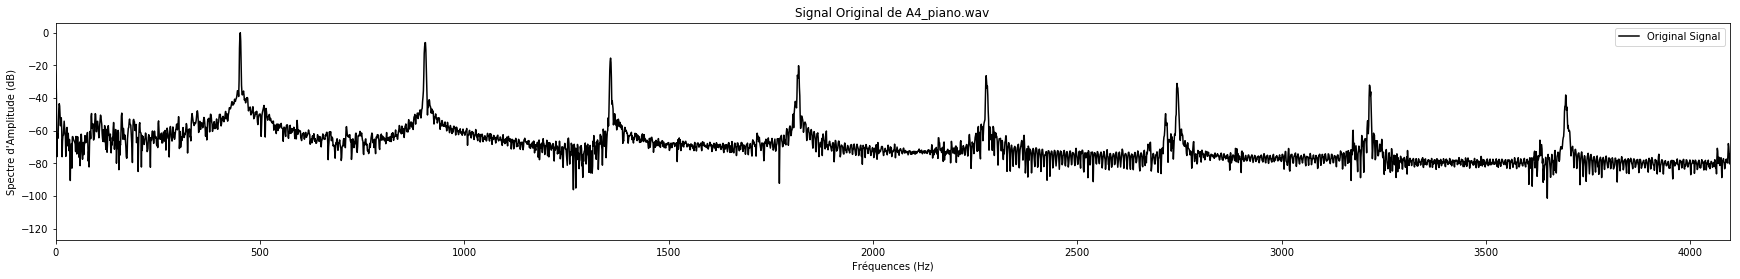

In [591]:
plt.figure(figsize=(30, 4))
plt.plot(20*np.log10(X_fft), color='k', label='Original Signal')
plt.xlim(0, Rmax)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title("Signal Original de "+filename)
plt.legend()
plt.show()

### Affichage du signal après supression d'harmonique

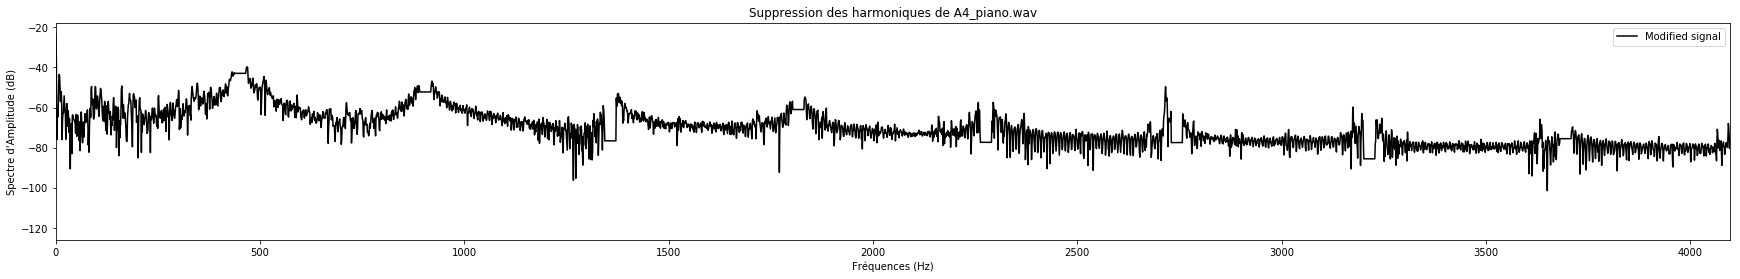

In [592]:
PP = harmonic_suppression(X_fft,Rmax,H,0.05,"product",frequencies)
plt.figure(figsize=(30, 4))
plt.plot(20*np.log10(PP), color='k', label='Modified signal')
plt.xlim(0, Rmax)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title("Suppression des harmoniques de "+filename)
plt.legend()
plt.show()

## 3.3) Stopping criterion with spectral sum

>Our stopping criterion doesn't work well with the spectral sum, but it works well with the Spectral Product.

In [593]:
# alpha = 0.7
# PP=X_fft
# method="sum"
# Thresh=0.01
# P_sum= spectral_method(PP, Rmax, H, method)
# S=P_sum[np.argmax(P_prod[Nmin:Nmax])+Nmin]
# j0=detect_harmonic(PP, Rmax, H, alpha,method,1,frequencies)
# while True:
#     P_sum= spectral_method(PP, Rmax, H, method)
#     S1=P_sum[np.argmax(P_sum[Nmin:Nmax])+Nmin]
#     j=detect_harmonic(PP, Rmax, H, alpha,method,1,frequencies)
#     if S1<Thresh*S:
#         break
#     else:
#         print("suppression of the frequency "+ str(frequencies[j]) +" Hz and its harmonics")
#         PP=harmonic_suppression(PP,Rmax,H,alpha,method,frequencies)


In [594]:
# plt.figure(figsize=(30, 4))
# plt.plot(20*np.log10(PP), color='k', label='Modified signal')
# plt.xlim(0, Rmax)
# plt.xlabel('Fréquences (Hz)')
# plt.ylabel('Spectre d\'Amplitude (dB)')
# plt.title("Suppression des harmoniques avec le Stopping Criterion pour "+filename)
# plt.legend()
# plt.show()

# 4.1) Stopping criterion with spectral product

In [595]:
PP=X_fft
method="product"
Thresh=0.0001
P_sum= spectral_method(PP, Rmax, H, method)
S=P_sum[np.argmax(P_prod[Nmin:Nmax])+Nmin]
j0=detect_harmonic(PP, Rmax, H, 0.03,method,1,frequencies)
while True:
    P_sum= spectral_method(PP, Rmax, H, method)
    S1=P_sum[np.argmax(P_sum[Nmin:Nmax])+Nmin]
    j=detect_harmonic(PP, Rmax, H, 0.03,method,1,frequencies)
    if S1<Thresh*S:
        break
    else:
        print("suppression of the frequency "+ str(frequencies[j]) +" Hz and its harmonics")
        PP=harmonic_suppression(PP,Rmax,H,0.03,method,frequencies)


suppression of the frequency 441.40625 Hz and its harmonics


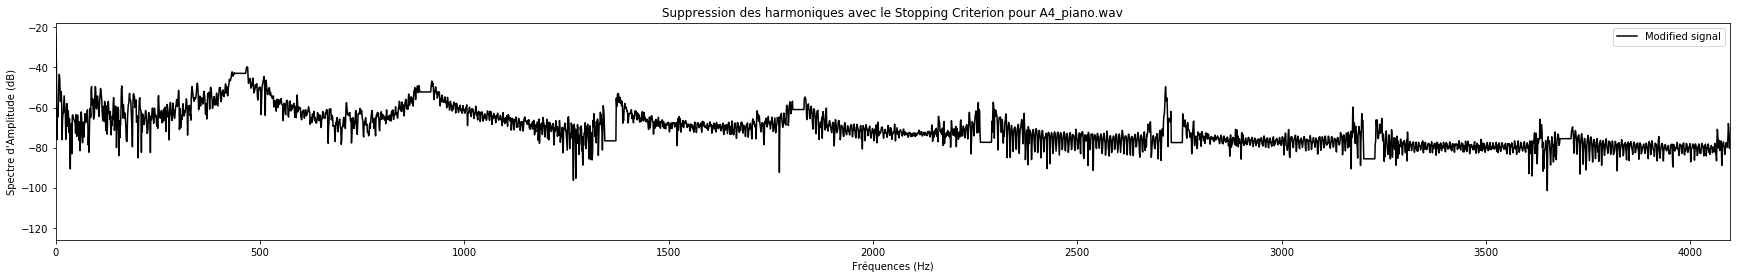

In [596]:
plt.figure(figsize=(30, 4))
plt.plot(20*np.log10(PP), color='k', label='Modified signal')
plt.xlim(0, Rmax)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title("Suppression des harmoniques avec le Stopping Criterion pour "+filename)
plt.legend()
plt.show()

## 4.2) Taking account of inharmonicity

In [597]:
def detect_harmonic_beta(x,R,H,alpha,method,k,freq,beta):
    """
    x:
    R:
    H:
    alpha:
    method:
    k:
    freq
    """
    P_sum= spectral_method(x, R, H, method)
    f=freq[np.argmax(P_sum[Nmin:Nmax])+Nmin]
    
    f_kmin=f*k*(1-alpha)*np.sqrt(1+(k**2)*beta)
    f_kmax=f*k*(1+alpha)*np.sqrt(1+(k**2)*beta)
    i0=f2idx(f*k,df)
    i=i0
    if i0==0:
        return(i0)
        
    else:
        while freq[i]>=f_kmin:
            if abs(x[i])>abs(x[i0]) :
                i0=i
            i=i-1
        while freq[i]<=f_kmax:
            if abs(x[i])>abs(x[i0]) :
                i0=i
            i+=1
            if i>=len(freq)-2*i0:
                break
        return(i0)

In [598]:
beta=0.005
print("The second harmonic frequency :  ", frequencies[detect_harmonic_beta(X_fft, Rmax, H, 0.02,"product",2,frequencies,beta)],
      "which is different from 1 x F0 = ", 2* frequencies[detect_harmonic_beta(X_fft, Rmax, H, 0.02,"product",1,frequencies,beta)] )
print("The third harmonic frequency :  ", frequencies[detect_harmonic_beta(X_fft, Rmax, H, 0.02,"product",3,frequencies,beta)],
      "which is different from 3 x F0 = ", 3* frequencies[detect_harmonic_beta(X_fft, Rmax, H, 0.02,"product",1,frequencies,beta)] )

The second harmonic frequency :   883.7890625 which is different from 1 x F0 =  882.8125
The third harmonic frequency :   1326.171875 which is different from 3 x F0 =  1324.21875


In [599]:
PP=X_fft
method="product"
Thresh=0.0001
P_sum= spectral_method(PP, Rmax, H, method)
S=P_sum[np.argmax(P_prod[Nmin:Nmax])+Nmin]
j0=detect_harmonic_beta(PP, Rmax, H, 0.03,method,1,frequencies,beta)
while True:
    P_sum= spectral_method(PP, Rmax, H, method)
    S1=P_sum[np.argmax(P_sum[Nmin:Nmax])+Nmin]
    j=detect_harmonic_beta(PP, Rmax, H, 0.03,method,1,frequencies,beta)
    if S1<Thresh*S:
        break
    else:
        print("suppression of the frequency "+ str(frequencies[j]) +" Hz and its harmonics")
        PP=harmonic_suppression_beta(PP,Rmax,H,0.03,method,frequencies)


suppression of the frequency 441.40625 Hz and its harmonics


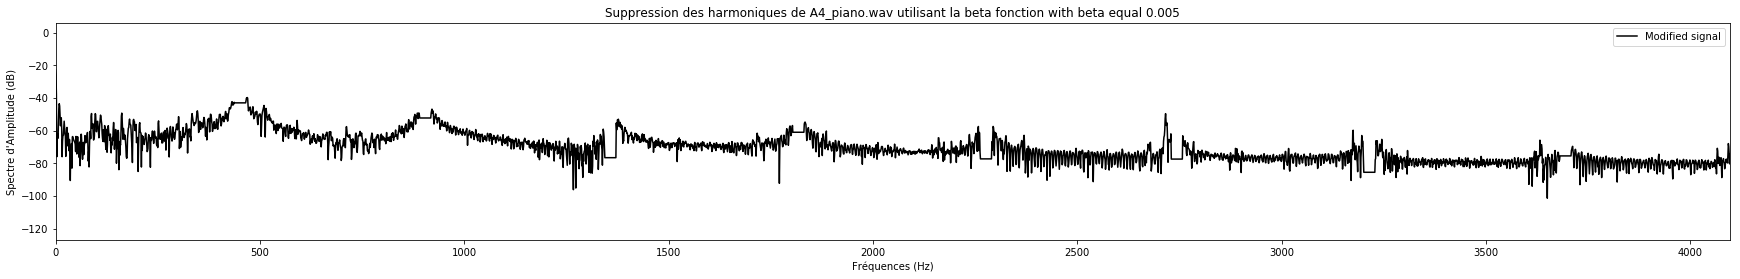

In [600]:
plt.figure(figsize=(30, 4))
plt.plot(20*np.log10(PP), color='k', label='Modified signal')
plt.xlim(0, Rmax)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title("Suppression des harmoniques de "+filename+" utilisant la beta fonction with beta equal "+str(beta))
plt.legend()
plt.show()